In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
import os

In [2]:
baseline_df = pd.read_csv('Curated_Data_Cuts_Files/PPMI_Baseline_Data_02Jul2018.csv')
years_df = pd.read_csv('Curated_Data_Cuts_Files/PPMI_Year_1-3_Data_02Jul2018.csv')
mri_df = pd.read_csv('download/Magnetic_Resonance_Imaging.csv')

In [3]:
## Get patient numbers with MRI scans
mri_patno_counts = mri_df["PATNO"].value_counts()
mri_ids = mri_patno_counts.index

In [4]:
## Get patient numbers with critical info and MRI scans
baseline_patno_counts = baseline_df["PATNO"].value_counts()
baseline_ids = baseline_patno_counts.index
# print(len(baseline_ids))
years_patno_counts = years_df["PATNO"].value_counts()
years_ids = years_patno_counts.index
# print(len(years_ids))
stage_data_ids = pd.Series(list(set(years_ids) & set(baseline_ids)))
# print(stage_data_ids.shape)
both_ids = pd.Series(list(set(stage_data_ids) & set(mri_ids)))
# print(both_ids.shape)

In [5]:
## Limit dfs to relevant patient numbers
baseline_df = baseline_df[baseline_df['PATNO'].isin(both_ids)]
years_df = years_df[years_df['PATNO'].isin(both_ids)]
mri_df = mri_df[mri_df['PATNO'].isin(both_ids)]

In [6]:
## Define columns in years biomarker df
years_df.set_index('EVENT_ID')
years_col = years_df.columns

years_col_discard = [
    'EVENT_ID', 'SITE', 'hy_on', 'NHY', 'NHY_ON',
    'NP1ANXS', 'NP1APAT', 'NP1COG', 'NP1DDS', 'NP1DPRS', 'NP1FATG', 'NP1HALL',
    'othneuro', 'updrs1_score', 'updrs2_score', 'updrs3_score', 'updrs3_score', 'updrs_totscore', 'updrs_totscore_on'
]
years_col_keep = years_col.drop(years_col_discard)
col_stage = 'hy'

years_bm = years_df[years_col_keep]

In [31]:
## Define columns in baseline biomarker df
baseline_col = baseline_df.columns
same_col = years_col.intersection(baseline_col)
same_col = same_col.drop(['PATNO'])
only_baseline_col = baseline_col.drop(same_col)
baseline_col_keep = only_baseline_col.drop(['symptom5_comment', 'APOE', 'SNCA_rs356181', 'SNCA_rs3910105', 'MAPT']) ## this is mostly null
baseline_bm = baseline_df[baseline_col_keep]

In [8]:
## Merge baseline data into years data
merged_df = years_bm.merge(baseline_bm, on='PATNO', suffixes=(False, '_bl'))
print(merged_df.shape)

(1783, 133)


In [9]:
## Standardize null format, keep biomarkers with >=80% representation
merged_df_nulls = merged_df.replace('.', np.nan)
col_nulls = merged_df_nulls.isnull().sum(axis = 0) / merged_df.shape[0]
merged_col_keep = [i for i in (col_nulls < 0.2).index if (col_nulls < 0.2)[i]]
merged_bm = merged_df_nulls[merged_col_keep]

In [10]:
## Remove rows with nulls from merged data
merged_bm_hasna = merged_bm[merged_bm.isna().any(axis=1)]
drop_rows = merged_bm_hasna.index
# print(drop_rows.shape)  ## this is the amt of rows dropped
merged_full = merged_bm.drop(drop_rows)
print(merged_full.shape)

(1154, 78)


In [11]:
for i in merged_full.columns:
    merged_full[i] = pd.to_numeric(merged_full[i],errors='coerce')

In [32]:
merged_full.to_csv('cleaned_critical_biomarkers_data.csv')

In [33]:
test_cols = ['hy', 'urate', 'age', 'gen', 'race', 'APOE_e4', 'SNCA_rs356181_cat', 'SNCA_rs3910105_cat', 'MAPT_cat', 'moca']
test_set = merged_full[test_cols].head(100)
test_set.to_csv('test_biomarkers_data.csv')

In [34]:
test_zscore = stats.zscore(test_set, axis=0, ddof=1)
test_set_norm = pd.DataFrame(test_zscore, index=test_set.index)
test_set.to_csv('sustain/test_data/test_biomarkers_data_norm.csv')
# print(test_set_norm.head(1))

In [35]:
test_min_zscore = pd.DataFrame(test_set_norm.min(axis=0)).T
print(test_min_zscore.shape)
test_min_zscore.to_csv('sustain/test_data/test_min_zscore.csv')

(1, 10)


In [36]:
test_max_zscore = pd.DataFrame(test_set_norm.max(axis=0)).T
print(test_max_zscore.shape)
test_max_zscore.to_csv('sustain/test_data/test_max_zscore.csv')

(1, 10)


In [37]:
test_std_zscore = pd.DataFrame(test_set_norm.std(axis=0)).T
print(test_std_zscore.shape)
print(test_std_zscore)
test_std_zscore.to_csv('sustain/test_data/test_std_zscore.csv')

(1, 10)
     0    1    2    3    4    5    6    7    8    9
0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0


In [19]:
test_stage_zscore = pd.DataFrame(test_set_norm.mean(axis=0)).T
# print(test_stage_zscore)
test_bm_index = pd.DataFrame([[i for i in range(10)]])
# print(test_bm_index)

In [29]:
import sustain_funcs

Finding ML solution to 1 cluster problem
 ++ startpoint 0


IndexError: index -1 is out of bounds for axis 0 with size 0

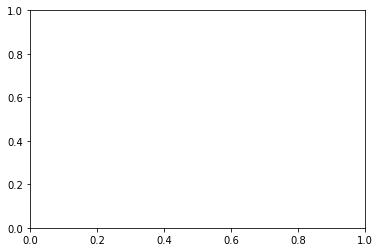

In [30]:
# import pdb; pdb.set_trace()
# test_out = sustain_funcs.run_sustain_algorithm(
#     test_set_norm,
#     test_min_zscore,
#     test_max_zscore,
#     test_std_zscore,
#     test_stage_zscore,
#     test_bm_index,
#     25,
#     10,
#     1000000,
#     'Approx',
#     'sustain',
#     'Test Critical Biomarker Set'
# )

In [21]:
print(mri_df.columns)

Index(['REC_ID', 'F_STATUS', 'PATNO', 'EVENT_ID', 'PAG_NAME', 'INFODT',
       'MRICMPLT', 'MRIDT', 'MRIWDTI', 'MRIWRSS', 'MRIXFRYN', 'MRIRSLT',
       'PDMEDYN', 'ONLDOPA', 'ONDOPAG', 'ONOTHER', 'PDMEDDT', 'COMM',
       'ORIG_ENTRY', 'LAST_UPDATE', 'QUERY', 'SITE_APRV'],
      dtype='object')


In [22]:
print(mri_df.head(1))

      REC_ID F_STATUS  PATNO EVENT_ID PAG_NAME   INFODT  MRICMPLT    MRIDT  \
0  234501601        V   3400       BL      MRI  07/2010       1.0  07/2010   

   MRIWDTI  MRIWRSS  ...  PDMEDYN  ONLDOPA  ONDOPAG  ONOTHER  PDMEDDT  \
0      0.0      NaN  ...      NaN      NaN      NaN      NaN      NaN   

                                                COMM ORIG_ENTRY  \
0  Partially empty sella and question of flatteni...    07/2010   

             LAST_UPDATE QUERY SITE_APRV  
0  2010-07-22 11:19:05.0   NaN   07/2010  

[1 rows x 22 columns]
